## Importing libraries required for this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score

from sklearn.inspection import permutation_importance 
#from pdpbox.pdp import pdp_isolate,pdp_plot,pdp_interact,pdp_interact_plot
import shap

import seaborn as sns

# I. Wrangle Data

In [62]:
def wrangle(filepath):
    df = pd.read_csv(filepath,index_col ='id')
    
   
    categorical_cols = df.select_dtypes('object').columns
    
    # Drop high-cardinality categorical variables and those not needed
    high_card_cols = ['name','listing_url','host_id','description','neighborhood_overview','picture_url','host_url',
                       'host_name','host_since','host_location', 'host_about','host_thumbnail_url','first_review','last_review',
                       'host_picture_url','host_neighbourhood','last_scraped','license','calendar_last_scraped',
                      'calculated_host_listings_count_shared_rooms','calculated_host_listings_count_private_rooms',
                      'calculated_host_listings_count_entire_homes','calculated_host_listings_count','number_of_reviews_ltm',
                      'host_verifications','minimum_minimum_nights','maximum_minimum_nights','minimum_nights_avg_ntm']
     
    df.drop(columns = high_card_cols, inplace=True)
    
    #drop constant variables and empty columns
    df.drop(columns = ['scrape_id','neighbourhood','neighbourhood_group_cleansed','bathrooms',
                       'calendar_updated','property_type','beds'],inplace =True)
    
    #Droping '$' from price
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].astype(float)

    #Removing outliers from 'price'
    df = df[(df['price'] >= np.percentile(df['price'], 0.5)) &
        (df['price'] <= np.percentile(df['price'], 99.5)) &
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) &
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) &
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
    
    #Cleaning bathroom text column
    df['bathrooms_text'] = df['bathrooms_text'].str.replace('baths', '')
    df['bathrooms_text'] = df['bathrooms_text'].str.replace('bath', '')
    df['bathrooms_text'] = df['bathrooms_text'].str.replace('private', '')
    df['bathrooms_text'] = df['bathrooms_text'].str.replace('shared', '')
    df['bathrooms_text'] = df['bathrooms_text'].str.replace('s', '')
    df['bathrooms_text'] = df['bathrooms_text'].str.replace('Shared half-', '')
    df['bathrooms_text'] = df['bathrooms_text'].str.replace('Half-', '')
    df['bathrooms_text'] = df['bathrooms_text'].str.replace('Private half-', '')
    df['bathrooms_text'] = df['bathrooms_text'].str.lstrip().str.rstrip()

    #Cleaning 'host_response_rate','host_acceptance_rate' columns
    df['host_response_rate']=df['host_response_rate'].str.strip('%').astype(float)
    df['host_response_rate']=df['host_response_rate'].fillna(df['host_response_rate'].mean())

    df['host_acceptance_rate']=df['host_acceptance_rate'].str.strip('%').astype(float)
    df['host_acceptance_rate']=df['host_acceptance_rate'].fillna(df['host_response_rate'].mean())

    #Feature Engineering
    #Count of amenities listed
    df['num_of_amenities'] = df['amenities'].str.count(pat = ',') +1
    
    #Creating bathrooms column
    df['bathrooms'] = pd.to_numeric(df['bathrooms_text'])
    df['bathrooms']
    
    #Removing bathrooms_text,amenities column
    df.drop(columns=['bathrooms_text','amenities'],inplace=True)
    
    #Fillna
    df['review_scores_rating']=df['review_scores_rating'].fillna(df['review_scores_rating'].mean())
    df['review_scores_accuracy']=df['review_scores_accuracy'].fillna(df['review_scores_accuracy'].mean())
    df['review_scores_cleanliness']=df['review_scores_cleanliness'].fillna(df['review_scores_cleanliness'].mean())
    df['review_scores_checkin']=df['review_scores_checkin'].fillna(df['review_scores_checkin'].mean())
    df['review_scores_communication']=df['review_scores_communication'].fillna(df['review_scores_communication'].mean())
    df['review_scores_location']=df['review_scores_location'].fillna(df['review_scores_location'].mean())
    df['review_scores_value']=df['review_scores_value'].fillna(df['review_scores_value'].mean())
    df['reviews_per_month']=df['reviews_per_month'].fillna(df['reviews_per_month'].mean())

    df['host_response_time'] =df['host_response_time'].fillna('within an hour')

    return df

In [64]:
df = wrangle('../notebooks/AirBnb/listings_detailed.csv')

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


In [4]:
df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,num_of_amenities,bathrooms
id,,,,,,,,,,,,,,,,,,,,,
958,within an hour,90.000000,90.000000,t,1.0,1.0,t,t,Western Addition,37.77028,...,10.0,10.0,10.0,10.0,10.0,10.0,f,1.95,31,1.0
5858,within a few hours,100.000000,79.000000,f,2.0,2.0,t,t,Bernal Heights,37.74511,...,10.0,10.0,10.0,10.0,10.0,9.0,f,0.77,16,1.0
7918,within an hour,92.955305,92.955305,f,10.0,10.0,t,t,Haight Ashbury,37.76555,...,7.0,8.0,9.0,9.0,9.0,8.0,f,0.14,16,4.0
8142,within an hour,92.955305,92.955305,f,10.0,10.0,t,t,Haight Ashbury,37.76555,...,9.0,9.0,10.0,10.0,9.0,9.0,f,0.10,15,4.0
8339,within an hour,100.000000,0.000000,f,2.0,2.0,t,t,Western Addition,37.77525,...,10.0,10.0,10.0,10.0,10.0,10.0,f,0.20,26,1.5


### Generate a ProfileReport to help with the wrangle function

In [5]:
ProfileReport(df, minimal= True)

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


In [6]:
df.shape

(6804, 38)

## II. Split Data
### First we need to split our target vector from our feature matrix.

In [5]:
target = 'price'
X = df.drop(columns = target)
y = df[target]

### **Second** we need to split our dataset into **training** and **test** sets.

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#Checking shape of train and test sets
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)

print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_train shape: (5443, 37)
y_train shape: (5443,)
X_test shape: (1361, 37)
y_test shape: (1361,)


# III. Establish Baseline

- Since this is a Regression problem , our baseline will be the mean of the Y_train values

In [9]:
#To establish a baseline we use the mean and make an array with the mean value the length of y
y_pred = [y_train.mean()] * len(y_train)
print("Mean price :", y_train.mean())

#Calculating the baseline MAE
baseline_MAE = mean_absolute_error(y_train,y_pred)
print("Baseline MAE is :", baseline_MAE)

Mean price : 186.51166636046298
Baseline MAE is : 111.03476717555435


# IV. Build Model

In [10]:
#Model 1: Linear Regression:
model_lr = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         StandardScaler(),
                         LinearRegression()
)

In [11]:
#Model 2: Ridge
model_r = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         Ridge()                       
)

In [12]:
#Model 3: RandomForest

model_rfr = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestRegressor(random_state = 42,n_jobs=-1)                       
)

In [13]:
#Model4 : XGBoost
model_gb = make_pipeline(OrdinalEncoder(),
                         XGBRegressor(random_state=42,n_jobs=-1)
)

# V. Check Metrics

### Cross validation score

- By default uses R2

In [14]:
lr_cross_val_score = cross_val_score(model_lr,X_train,y_train, cv=5,n_jobs =-1)

print("LR cross validation score - Mean:",lr_cross_val_score.mean())
print("LR cross validation score - Std:",lr_cross_val_score.std())

LR cross validation score - Mean: -11349716.008900879
LR cross validation score - Std: 22699432.7870005


In [15]:
r_cv_score = cross_val_score(model_r,X_train,y_train,cv=5,n_jobs=-1)

print("Ridge cross validation score - Mean:",r_cv_score.mean())
print("Ridge cross validation score - Std:",r_cv_score.std())

Ridge cross validation score - Mean: -11196656.880509716
Ridge cross validation score - Std: 22393314.52313996


In [16]:
rfr_cv_score = cross_val_score(model_rfr,X_train,y_train,cv=5,n_jobs=-1)

print("RF cross validation score - Mean:",rfr_cv_score.mean())
print("RF cross validation score - Std:",rfr_cv_score.std())

RF cross validation score - Mean: 0.6380023822301231
RF cross validation score - Std: 0.037675032911214115


In [17]:
xgb_cv_score = cross_val_score(model_gb,X_train,y_train,cv=5,n_jobs=-1)

print("XGB cross validation score - Mean:",xgb_cv_score.mean())
print("XGB cross validation score - Std:",xgb_cv_score.std())

XGB cross validation score - Mean: 0.6412080675921061
XGB cross validation score - Std: 0.03770590897608753



- When setting score: negative mean abs error

In [18]:
lr_score = cross_val_score(model_lr,X_train, y_train,cv=5, scoring='neg_mean_absolute_error')
print("LR cross_val_score Neg MAE:",lr_score.mean())

LR cross_val_score Neg MAE: -8888.296895609403


In [19]:
ridge_score = cross_val_score(model_r,X_train, y_train,cv=5, scoring='neg_mean_absolute_error')
print("Ridge cross_val_score Neg MAE:",ridge_score.mean())

Ridge cross_val_score Neg MAE: -8827.992785827628


In [20]:
rfr_score = cross_val_score(model_rfr,X_train, y_train,cv=5, scoring='neg_mean_absolute_error')
print("RF cross_val_score Neg MAE:",rfr_score.mean())

RF cross_val_score Neg MAE: -58.420359916676816


In [21]:
gb_score = cross_val_score(model_gb,X_train, y_train,cv=5, scoring='neg_mean_absolute_error') 
print("XGB cross_val_score Neg MAE:",gb_score.mean())

XGB cross_val_score Neg MAE: -58.81474598202241


### Observations

- Based on the cross validation score by both R2 and Negative mean absolute error we can see that the RandomForestRegressor performs the best.

# VI. Model Tuning

### We will first use RandomizedSearchCV and if required GridSearchCV for hyperparameter tuning

In [22]:

param_grid = {'randomforestregressor__max_depth': range(35,61,5),
              'randomforestregressor__n_estimators': range(390, 501, 50),
              'randomforestregressor__criterion': ['mae']}

In [23]:
model_rs = RandomizedSearchCV(model_rfr,
                              param_distributions=param_grid,
                              n_iter=3,n_jobs=-1,
                              cv=5,verbose=10)
model_rs.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed: 20.3min remaining: 131.8min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 20.6min remaining: 56.6min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 20.9min remaining: 31.3min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 21.3min remaining: 18.6min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 37.0min remaining: 18.5min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 37.2min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 37.6min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'randomforestregressor__criterion': ['mae'],
                                        'randomforestregressor__max_depth': range(35, 61, 5),
                                        'randomforestregressor__n_estimators': range(390, 501, 50)},
                   verbose=10)

In [24]:
print(model_rs.best_params_)



{'randomforestregressor__n_estimators': 440, 'randomforestregressor__max_depth': 40, 'randomforestregressor__criterion': 'mae'}


### Using the best params to tune the RandomForest model

In [7]:
model_rfr_tuned = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestRegressor(n_estimators = 490,max_depth=40,criterion ='mae',random_state = 42,n_jobs=-1)                       
)

In [26]:
#Checking metric to evaluate model performance

rfr_cv_score = cross_val_score(model_rfr_tuned,X_train,y_train,cv=5,n_jobs=-1)

print("RF cross validation score - Mean:",rfr_cv_score.mean())
print("RF cross validation score - Std:",rfr_cv_score.std())

RF cross validation score - Mean: 0.6578546282876101
RF cross validation score - Std: 0.03829497713376066


In [27]:
rfr_score = cross_val_score(model_rfr_tuned,X_train, y_train,cv=5, scoring='neg_mean_absolute_error')
print("RF tuned cross_val_score Neg MAE:",rfr_score.mean())

RF tuned cross_val_score Neg MAE: -57.09757556259418


#### We can see that by both metrics the tuned model performs better. For this reason we will use this for our predictions.

# VII. Communicate results

- X_test listing price predictions 
- Permutation importance
- Visualisation using PDP and Shapley plots


In [15]:
model_rfr_tuned

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(criterion='mae', max_depth=40,
                                       n_estimators=490, n_jobs=-1,
                                       random_state=42))])

In [8]:
#training the tuned model for predictions and permutation importance
model_rfr_tuned.fit(X_train,y_train);

- X_test Price predictions

In [9]:
predict = model_rfr_tuned.predict(X_test)
predict[:50]

array([336.62653061,  71.80612245, 147.54489796, 179.33061224,
       336.20816327, 569.4244898 , 285.7       ,  91.86326531,
       290.95714286, 127.60408163, 631.7755102 , 359.8244898 ,
        98.61632653, 221.90918367, 841.20306122,  57.53367347,
       121.62346939, 174.8122449 , 126.30612245,  66.13265306,
       123.67142857, 267.62653061,  98.05510204, 276.03265306,
       142.43673469, 137.77346939, 203.09183673, 139.95816327,
        69.86734694, 174.34081633,  82.52142857, 191.08061224,
       267.60204082, 158.99285714,  46.73469388,  70.23469388,
       162.7244898 , 186.71020408,  91.78979592, 344.8       ,
        78.05      , 774.71530612, 101.50204082, 346.60612245,
       190.73367347, 262.72040816, 214.69285714, 496.83163265,
        86.88367347,  98.71632653])

In [10]:
#Checking the test score (MAE) using true values = y_test and the predicted values = predict
test_score = mean_absolute_error(y_test,predict)
print("The prediction MAE is : ",test_score)

The prediction MAE is :  53.93788930708213


- Permutation Importance

In [11]:
perm_imp = permutation_importance(model_rfr_tuned,X_train,y_train,n_repeats=5,n_jobs =-1,random_state=42)

In [12]:
data = {'imp_mean':perm_imp['importances_mean'],
     'imp_std':perm_imp['importances_std']}


permutation_importance = pd.DataFrame(data,index=X_train.columns).sort_values('imp_mean')
permutation_importance.tail(25)

,imp_mean,imp_std
maximum_nights_avg_ntm,0.006415,0.000341
minimum_maximum_nights,0.006738,0.000360
host_response_time,0.006788,0.000195
review_scores_checkin,0.008667,0.000952
availability_60,0.010190,0.000656
availability_30,0.011020,0.000252
availability_90,0.011781,0.000505
neighbourhood_cleansed,0.014640,0.000727
maximum_nights,0.017321,0.001245
number_of_reviews,0.021246,0.001116


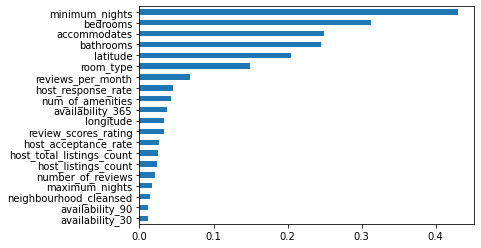

In [33]:
permutation_importance['imp_mean'].tail(20).plot(kind='barh');

### Observations:

Based on the permutation importance plot we can see that the top 6 influential features are:
- Minimum nights required to stay
- No. of Bedrooms
- No. of people the listing can accomodate
- No. of Bathrooms
- Location
- Room type

These seem to be resonable and in accordance to what I thought would be big influencers in the predictions

## PDP Plots and Shapley

- Building and training a model without using a pipeline in order to visualize using Shapley

In [34]:
encoder = OrdinalEncoder()
encoder.fit(X_train)
XT_train = encoder.transform(X_train)
XT_train.fillna(X_train.mean(), inplace=True)   #used inplace of SimpleImputer
model_standalone = RandomForestRegressor(n_estimators = 490,max_depth=40,criterion ='mae',random_state = 42,n_jobs=-1)

In [35]:
model_standalone.fit(XT_train,y_train);


### PDP plots

- One feature 

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='accommodates'>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


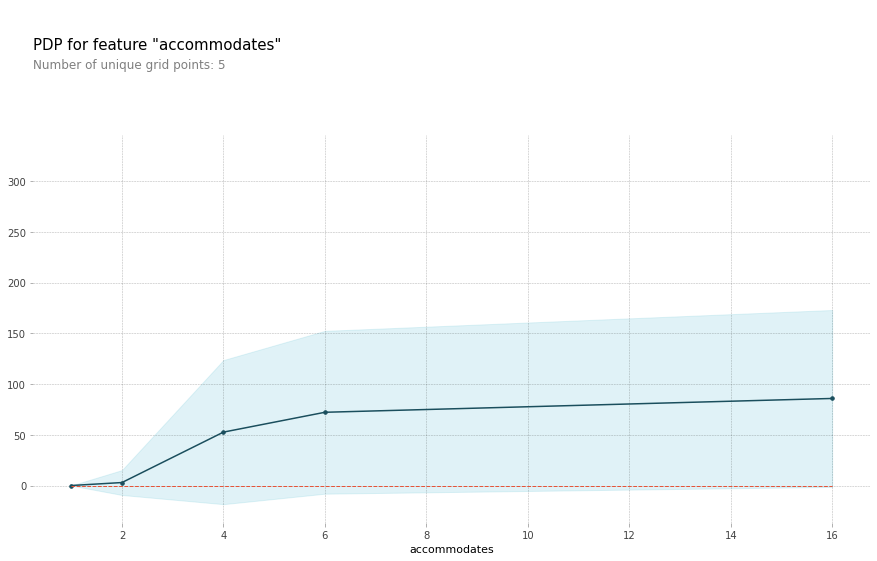

In [36]:
feature = 'accommodates'

isolate = pdp_isolate(
    model_standalone,
    dataset=XT_train, 
    model_features=XT_train.columns,
    feature=feature
)
  
pdp_plot(isolate,feature_name=feature)

### Observations:
- Based on the **single feature PDP Plot** we can see that as the number of people that a listing can accomodate increases, the predicted price also increases.




- Two features

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


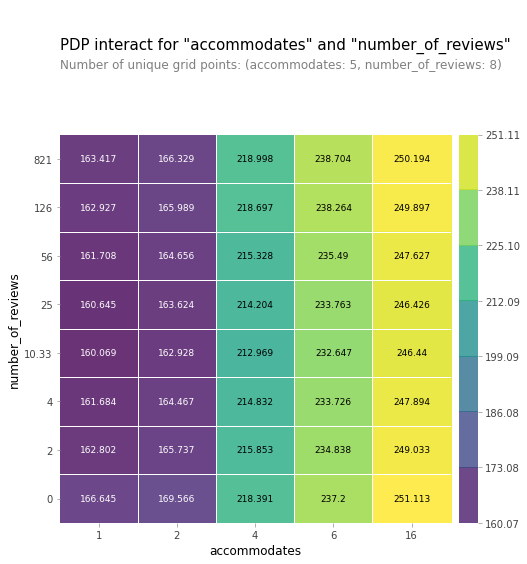

In [37]:
features = ['accommodates','number_of_reviews']

interact = pdp_interact(
    model = model_standalone,
    dataset=XT_train,
    model_features=XT_train.columns,
    features= features)

pdp_interact_plot(interact, plot_type='grid', feature_names= features);

### Observation
- The number_of_reviews plays a more vital role in predicting the price of a listing specifically for those that accommodate more than 10 people.

### Shapley plots

- Plot for the 1st listing

In [38]:
row = XT_train.head(1)
row

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,num_of_amenities,bathrooms
id,,,,,,,,,,,,,,,,,,,,,
5019863,1,100.0,92.955305,1,1.0,1.0,1,1,1,37.75865,...,10.0,9.0,10.0,10.0,10.0,9.0,1,0.42,21,1.0


In [39]:
explainer = shap.TreeExplainer(model_standalone) 
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

Based on this , we can see that for this listing the predicted price is $148.11. 
In order to make this prediction:
- the model pushed upwards features like number_of_reviews and host_acceptance_rate
- the features like 'accomodates','room_type','bedrooms' etc were pushed downwards

In [43]:
row1 = XT_train.tail(1)
row1

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,num_of_amenities,bathrooms
id,,,,,,,,,,,,,,,,,,,,,
3257886,1,100.0,100.0,2,2.0,2.0,1,1,14,37.76391,...,10.0,10.0,10.0,10.0,10.0,10.0,2,6.58,36,1.0


In [44]:
#explainer = shap.TreeExplainer(model_standalone) 
shap_values = explainer.shap_values(row1)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row1)

### Shapley Plot to show feature interactions

In [40]:
shap_values = explainer.shap_values(XT_train)

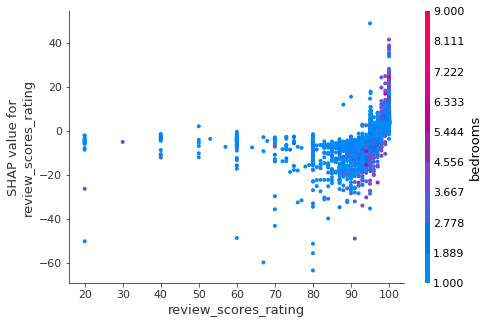

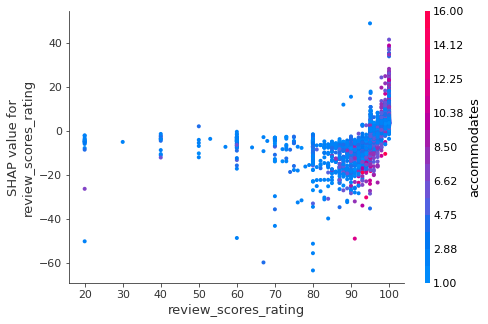

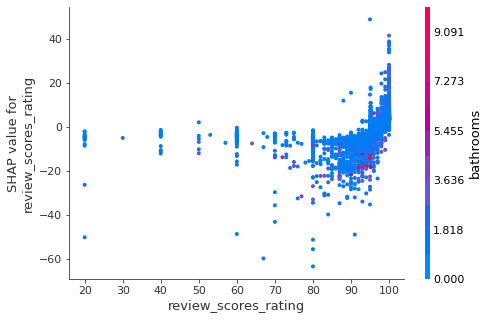

In [41]:
# we can use shap.approximate_interactions to guess which features
# may interact with review_scores_rating
inds = shap.approximate_interactions("review_scores_rating", shap_values, XT_train)
# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("review_scores_rating", shap_values, XT_train, interaction_index=inds[i])

### Observations:

- This shows the top 3 features that interact with the feature 'review_scores_rating'
- This also shows what the interactions are between them

## WebApp

Use the top 5 features from permutation_importance

In [39]:

df_features_filtered = permutation_importance.tail(20)


In [40]:
df_features_filtered

,imp_mean,imp_std
availability_30,0.011020,0.000252
availability_90,0.011781,0.000505
neighbourhood_cleansed,0.014640,0.000727
maximum_nights,0.017321,0.001245
number_of_reviews,0.021246,0.001116
host_listings_count,0.023985,0.001460
host_total_listings_count,0.024712,0.001346
host_acceptance_rate,0.026494,0.001748
review_scores_rating,0.033425,0.000267
longitude,0.033815,0.000873


### Using the top 20 influential features and then filtering to get only required ones for webapp

In [59]:
feature_list = df_features_filtered.index.tolist()
remove_list =['availability_30','availability_90','maximum_nights','host_listings_count','host_total_listings_count','availability_365','num_of_amenities','host_response_rate','reviews_per_month','number_of_reviews','host_acceptance_rate','review_scores_rating','longitude','latitude']
for ele in remove_list:
    if ele in feature_list:
        feature_list.remove(ele)

feature_list

['neighbourhood_cleansed',
 'room_type',
 'bathrooms',
 'accommodates',
 'bedrooms',
 'minimum_nights']

Using the top features to train RFRegressor Model

In [60]:
X_train_feature_filtered = X_train[feature_list]

model_filtered = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state = 42,n_jobs=-1) 
)

# Fit and score on train.
model_filtered.fit(X_train_feature_filtered, y_train)
print('Accuracy - MAE :', mean_absolute_error(y_train,model_filtered.predict(X_train_feature_filtered)))

Accuracy - MAE : 40.632643943052145


Save model in .joblib

In [61]:

from joblib import dump
dump(model_filtered, 'model.joblib', compress=True)

['model.joblib']

### Check description of continous variables - numerical features


In [48]:

con_cols =  X_train_feature_filtered.select_dtypes(exclude='object').columns.tolist()


for con in con_cols:
    print( X_train_feature_filtered[con].describe())

count    5443.000000
mean     -122.428960
std         0.026441
min      -122.509970
25%      -122.441575
50%      -122.423020
75%      -122.409910
max      -122.370050
Name: longitude, dtype: float64
count    5443.000000
mean       37.768101
std         0.022910
min        37.708410
25%        37.753160
50%        37.771430
75%        37.787270
max        37.806830
Name: latitude, dtype: float64
count    5425.000000
mean        1.387834
std         0.924809
min         0.000000
25%         1.000000
50%         1.000000
75%         1.500000
max        10.000000
Name: bathrooms, dtype: float64
count    5443.000000
mean        3.072019
std         1.866244
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        16.000000
Name: accommodates, dtype: float64
count    4747.000000
mean        1.497577
std         0.849471
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: bedrooms, dtype: float64

### Check unique values in each categorical variable

In [49]:
cat_cols = X_train_feature_filtered.select_dtypes(include='object').columns

for cat in cat_cols:
    print(cat)
    print(X_train_feature_filtered[cat].unique().tolist())

neighbourhood_cleansed
['Mission', 'South of Market', 'Bernal Heights', 'Nob Hill', 'Potrero Hill', 'Crocker Amazon', 'Bayview', 'Castro/Upper Market', 'Pacific Heights', 'Excelsior', 'Haight Ashbury', 'Downtown/Civic Center', 'Noe Valley', 'Outer Sunset', 'Western Addition', 'Parkside', 'Chinatown', 'North Beach', 'Twin Peaks', 'Financial District', 'Marina', 'Inner Sunset', 'Glen Park', 'Outer Mission', 'West of Twin Peaks', 'Inner Richmond', 'Ocean View', 'Seacliff', 'Russian Hill', 'Lakeshore', 'Presidio Heights', 'Outer Richmond', 'Golden Gate Park', 'Presidio', 'Visitacion Valley', 'Diamond Heights']
room_type
['Private room', 'Shared room', 'Entire home/apt', 'Hotel room']


In [50]:
# Getting version number of every package used in model pipeline
import joblib
import sklearn
import category_encoders as ce
import xgboost
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')


joblib==1.0.1
scikit-learn==0.24.1
category_encoders==2.2.2
xgboost==1.4.1
